GAN Example - Joseph Paul Cohen 2017

This is trained on MNIST based on DC-GAN and code from Francis Dutil

In [1]:
import theano
import numpy as np
import matplotlib.pylab as plt
import csv, os, random, sys

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: TITAN X (Pascal) (0000:09:00.0)


theano 0.9.0.dev-RELEASE
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

import gzip
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28).transpose(0,1,3,2)
    data = np.asarray([np.rot90(np.fliplr(x[0])) for x in data])
    data = data.reshape(-1, 1, 28, 28)
    return data / np.float32(255)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

x_train = load_mnist_images('train-images-idx3-ubyte.gz')
t_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
x_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
t_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
x_train, x_val = x_train[:-10000], x_train[-10000:]
t_train, t_val = t_train[:-10000], t_train[-10000:]

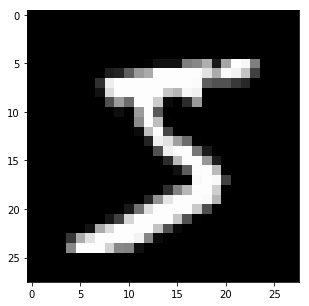

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(x_train[0][0],interpolation='none', cmap='gray');

In [5]:
num_units = 1024
encoder_size = 100
noise_size = 100

In [6]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, MaxPool2DLayer, Upscale2DLayer
from lasagne.layers import ConcatLayer, DropoutLayer, ReshapeLayer, TransposedConv2DLayer

In [7]:
gen_input_var = T.matrix("gen_input_var")

gen = lasagne.layers.InputLayer(shape=(None, noise_size),input_var=gen_input_var)
print gen.output_shape

gen = lasagne.layers.ReshapeLayer(gen, (-1, noise_size, 1, 1))
print gen.output_shape
gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units, filter_size=4, stride=1))
print gen.output_shape

gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units/2, filter_size=8, stride=1))
print gen.output_shape

gen = BatchNormLayer(TransposedConv2DLayer(gen, num_filters=num_units/4, filter_size=16, stride=1))
print gen.output_shape

gen = TransposedConv2DLayer(gen, num_filters=num_units/8, filter_size=6)
print gen.output_shape

gen = Conv2DLayer(gen, num_filters=1, filter_size=4, nonlinearity=lasagne.nonlinearities.sigmoid)
print gen.output_shape

(None, 100)
(None, 100, 1, 1)
(None, 1024, 4, 4)
(None, 512, 11, 11)
(None, 256, 26, 26)
(None, 128, 31, 31)
(None, 1, 28, 28)


In [8]:
lrelu = lasagne.nonlinearities.LeakyRectify(0.2)

disc = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=None)
print disc.output_shape

disc = BatchNormLayer(Conv2DLayer(disc, num_filters=num_units/4, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = BatchNormLayer(Conv2DLayer(disc, num_filters=num_units/2, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = (Conv2DLayer(disc, num_filters=num_units, filter_size=5, stride=2, pad=2, nonlinearity=lrelu))
print disc.output_shape

disc = FlattenLayer(disc)
disc = DenseLayer(disc, 1, nonlinearity=lasagne.nonlinearities.sigmoid)
print disc.output_shape

(None, 1, 28, 28)
(None, 256, 14, 14)
(None, 512, 7, 7)
(None, 1024, 4, 4)
(None, 1)


In [9]:
# create train functions 
lr = theano.shared(np.array(0., dtype=theano.config.floatX))

gen_output = lasagne.layers.get_output(gen)

one = T.constant(1., dtype=theano.config.floatX)
input_real = T.tensor4('target')


disc_output_fake = lasagne.layers.get_output(disc, inputs=gen_output)
disc_output_real = lasagne.layers.get_output(disc, inputs=input_real)
disc_loss = -(T.log(disc_output_real) + T.log(one-disc_output_fake)).mean()
disc_params = lasagne.layers.get_all_params(disc, trainable=True)
disc_updates = lasagne.updates.adam(disc_loss, disc_params, learning_rate=lr, beta1=0.5)


gen_loss = -T.log(disc_output_fake).mean()
gen_params = lasagne.layers.get_all_params(gen, trainable=True)
gen_updates = lasagne.updates.adam(gen_loss, gen_params, learning_rate=lr, beta1=0.5)


print "Computing functions"

gen_fn = theano.function([gen_input_var], gen_output, allow_input_downcast=True)

train_gen_fn = theano.function([gen_input_var], 
                               [gen_loss],
                               updates=gen_updates, 
                               allow_input_downcast=True)

disc_fn = theano.function([input_real], disc_output_real, allow_input_downcast=True)

train_disc_fn = theano.function([gen_input_var, input_real], 
                                [disc_loss],
                                updates=disc_updates,
                                allow_input_downcast=True)

print "Done"

Computing functions
Done


(10, 1, 28, 28)


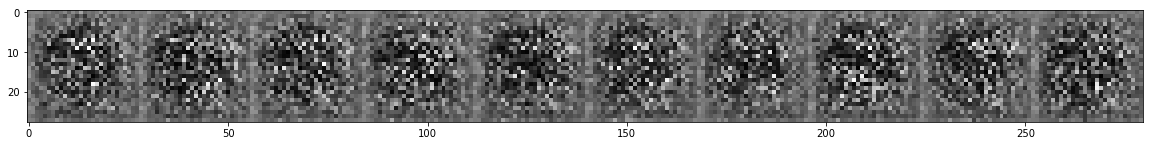

In [10]:
noise = np.random.uniform(size=(10, noise_size))
img = gen_fn(noise)
print img.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.imshow(np.concatenate(img[:,0], axis=1),interpolation='none', cmap='gray');

In [11]:
disc_fn(img)

array([[ 0.49940073],
       [ 0.50084448],
       [ 0.67724878],
       [ 0.5341537 ],
       [ 0.47612324],
       [ 0.43448931],
       [ 0.68808645],
       [ 0.510337  ],
       [ 0.48803958],
       [ 0.75813711]], dtype=float32)

In [12]:
disc_fn(x_train[:10])

array([[ 0.34576783],
       [ 0.20228077],
       [ 0.4019542 ],
       [ 0.52403039],
       [ 0.30479434],
       [ 0.54725045],
       [ 0.40102032],
       [ 0.40849492],
       [ 0.44777289],
       [ 0.2965647 ]], dtype=float32)

In [13]:
noise = np.random.normal(size=(1, noise_size))
train_gen_fn(noise)

[array(0.46438172459602356, dtype=float32)]

In [14]:
train_disc_fn(noise, x_train[:1])

[array(2.0832958221435547, dtype=float32)]

In [15]:
from scipy.ndimage.filters import gaussian_filter
def permute(img):
        
    rotation = random.choice([True, False])
    flip = random.choice([True, False])
    blur = random.randint(0,1)
    pad = random.randint(0,5)
    
    if (pad != 0):
        img = img[:,pad:-pad,pad:-pad]
        img = [scipy.misc.imresize(img[0], image_size), 
               scipy.misc.imresize(img[1], image_size), 
               scipy.misc.imresize(img[2], image_size)]
    
    if (blur != 0):
        img = gaussian_filter(img, sigma=blur)
    
    #rotate 
    if rotation:
        img = [np.rot90(img[0], 2),np.rot90(img[1], 2) ,np.rot90(img[2], 2)]
    
    #flip 
    if (flip):
        img = np.fliplr(img)  
    
    return img

In [16]:
num_samples = 1000

In [17]:
# ### D
# lr.set_value(0.0001)
# for i in range(10):
#     errs = []
#     for i in range(10):
#         noise = np.random.normal(size=(num_samples, noise_size))
#         samples = np.random.randint(0,len(x_train),num_samples)
#         err = train_disc_fn(noise, x_train[samples])
#         errs.append(err)
#     print "d",np.mean(errs)

In [18]:
# ### G
# lr.set_value(0.001)
# for i in range(1000):
#     errs = []
#     for i in range(5):
#         noise = np.random.normal(size=(num_samples, noise_size))
#         err = train_gen_fn(noise)
#         errs.append(err)
#     print "g",np.mean(errs)

In [19]:
lr.set_value(0.0001)
for j in range(100):
    err = 1
    while err > 0.5:
        noise = np.random.normal(size=(num_samples, noise_size))
        samples = np.random.randint(0,len(x_train),num_samples)
        err = train_disc_fn(noise, x_train[samples])[0]
    print "d",err

    err = 1
    while err > 0.5:
        noise = np.random.normal(size=(num_samples, noise_size))
        err = train_gen_fn(noise)[0]
    print "g",err

d 0.0125346612185
g 7.68578902353e-05
d 0.0615852698684
g 0.414748370647
d 0.103958331048
g 0.0718010738492
d 0.273212939501
g 0.452838987112
d 0.460355490446
g 0.376103579998
d 0.272418439388
g 0.34493470192
d 0.173762694001
g 0.189831957221
d 0.1034437567
g 0.168088853359
d 0.443502545357
g 0.278790801764
d 0.452911704779
g 0.425037235022
d 0.35163629055
g 0.484545350075
d 0.298340409994
g 0.371311455965
d 0.25411438942
g 0.286015421152
d 0.240971207619
g 0.397664904594
d 0.215131118894
g 0.395239621401
d 0.279808849096
g 0.305018156767
d 0.326014965773
g 0.255584985018
d 0.254886865616
g 0.31122636795
d 0.383832603693
g 0.457719683647
d 0.343939512968
g 0.474721610546
d 0.417410373688
g 0.414257079363
d 0.391638815403
g 0.347804367542
d 0.43119430542
g 0.378905326128
d 0.381533801556
g 0.391738861799
d 0.436962455511
g 0.411366254091
d 0.415748804808
g 0.408240109682
d 0.437764257193
g 0.44348269701
d 0.469886481762
g 0.400865793228
d 0.43006888032
g 0.338271051645
d 0.499684214592


(10, 1, 28, 28)


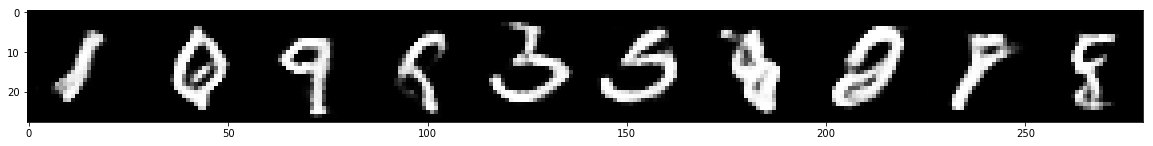

In [20]:
noise = np.random.uniform(size=(10, noise_size))
img = gen_fn(noise)
print img.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.imshow(np.concatenate(img[:,0], axis=1),interpolation='none', cmap='gray');